# Skillbox — Мастер-класс: Разведочный анализ данных + Подготовка отчётов — Kiva.org
***

# Новый раздел

# 4. Домашнее задание
***

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_rows = 87

In [2]:
loans_df = pd.read_csv('./data/12414_19728_compressed_kiva_loans.csv.zip', compression='zip', \
                       parse_dates = ['posted_time', 'disbursed_time', 'funded_time'])
regions_df = pd.read_csv('./data/datasets_12414_19728_kiva_mpi_region_locations.csv')

In [3]:
regions_df.head()

,LocationName,ISO,country,region,world_region,MPI,geo,lat,lon
0,"Badakhshan, Afghanistan",AFG,Afghanistan,Badakhshan,South Asia,0.387,"(36.7347725, 70.81199529999999)",36.734772,70.811995
1,"Badghis, Afghanistan",AFG,Afghanistan,Badghis,South Asia,0.466,"(35.1671339, 63.7695384)",35.167134,63.769538
2,"Baghlan, Afghanistan",AFG,Afghanistan,Baghlan,South Asia,0.300,"(35.8042947, 69.2877535)",35.804295,69.287754
3,"Balkh, Afghanistan",AFG,Afghanistan,Balkh,South Asia,0.301,"(36.7550603, 66.8975372)",36.755060,66.897537
4,"Bamyan, Afghanistan",AFG,Afghanistan,Bamyan,South Asia,0.325,"(34.8100067, 67.8212104)",34.810007,67.821210


In [4]:
loans_df.head()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01
3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variet...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,11.0,8,NaN,female,irregular,2014-01-01
4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,245.0,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,14.0,16,NaN,female,monthly,2014-01-01


## 4.1. Самостоятельная работа
***

- А в каких странах преобладают мужчины? Группа людей? (п. 2.2.2.)
- Изучите несколько займов с очень большими суммами. Что можно сказать о назначении этих заявок? В каких странах они оформлены? Каков гендерный состав заявителей? (п. 2.4.2.)
- Попробуйте найти связь между странами (регионами), полом заёмщика и суммой заявки. Какие выводы можно сделать из этих данных? (п. 2.4.3.)

In [5]:
loans_df['genders'] = loans_df['borrower_genders'].str.split(', ')

In [6]:
# увидим, что мужчины/женщины/отсутствующие сплитнулись правильно, нет лишних значений в столбце

loans_df['genders'] = loans_df.genders.fillna('-')
loans_df['genders'].apply(set).apply(str).unique()

array(["{'female'}", "{'male'}", "{'female', 'male'}", "{'-'}"],
      dtype=object)

In [7]:
loans_df['genders'] = loans_df.genders.apply(lambda x: dict(Counter(x)))
loans_df['group'], loans_df['females'], loans_df['males'] = 0, 0, 0

In [8]:
# Если в borrowed_genders м+ж или более одного м или ж, значит это группа

loans_df['group'] = loans_df.genders.map(lambda x: int(bool(((x.get('male', 0) > 0) & (x.get('female', 0) > 0)) \
                                                            | (x.get('male', 0) > 1) | (x.get('female', 0) > 1)))).values
loans_df['males'] = loans_df.genders.map(lambda x: int(x.get('male', 0))).values
loans_df['females'] = loans_df.genders.map(lambda x: int(x.get('female', 0))).values

In [9]:
grouped_loans_df = loans_df.groupby('country').agg({'females': 'sum', 'males': 'sum', 'group': ['sum', 'count']})
grouped_loans_df.columns = ['females_per_country', 'males_per_country', 'grouped_per_country', 'count']
grouped_loans_df['nogrouped_per_country'] = grouped_loans_df['count'] - grouped_loans_df['grouped_per_country']
grouped_loans_df = grouped_loans_df.drop('count', axis=1)

grouped_loans_df['genders_count'] = grouped_loans_df.males_per_country + grouped_loans_df.females_per_country
grouped_loans_df.insert(2, 'males_share', 100 * grouped_loans_df.males_per_country / grouped_loans_df.genders_count)
grouped_loans_df.insert(3, 'females_share', 100 * grouped_loans_df.females_per_country / grouped_loans_df.genders_count)

# grouped_loans_df.insert(6, 'group/nogroup ratio', grouped_loans_df['grouped_per_country'] / grouped_loans_df['nogrouped_per_country'])

grouped_loans_df['group_count'] = grouped_loans_df.grouped_per_country + grouped_loans_df.nogrouped_per_country
grouped_loans_df.insert(6, 'group_share', 100 * grouped_loans_df.grouped_per_country / grouped_loans_df.group_count)
grouped_loans_df.insert(7, 'nogroup_share', 100 * grouped_loans_df.nogrouped_per_country / grouped_loans_df.group_count)


In [10]:
grouped_loans_df

,females_per_country,males_per_country,males_share,females_share,grouped_per_country,nogrouped_per_country,group_share,nogroup_share,genders_count,group_count
country,,,,,,,,,,
Afghanistan,2,0,0.000000,100.000000,0,2,0.000000,100.000000,2,2
Albania,1018,899,46.896192,53.103808,0,1934,0.000000,100.000000,1917,1934
Armenia,5383,3245,37.610107,62.389893,0,8631,0.000000,100.000000,8628,8631
Azerbaijan,703,1207,63.193717,36.806283,3,1942,0.154242,99.845758,1910,1945
Belize,11,112,91.056911,8.943089,0,125,0.000000,100.000000,123,125
Benin,2295,50,2.132196,97.867804,443,54,89.134809,10.865191,2345,497
Bhutan,1,0,0.000000,100.000000,0,2,0.000000,100.000000,1,2
Bolivia,23087,4950,17.655241,82.344759,2587,6219,29.377697,70.622303,28037,8806
Brazil,651,187,22.315036,77.684964,167,117,58.802817,41.197183,838,284


В каких странах преобладают мужчины? Группа людей? (п. 2.2.2.)

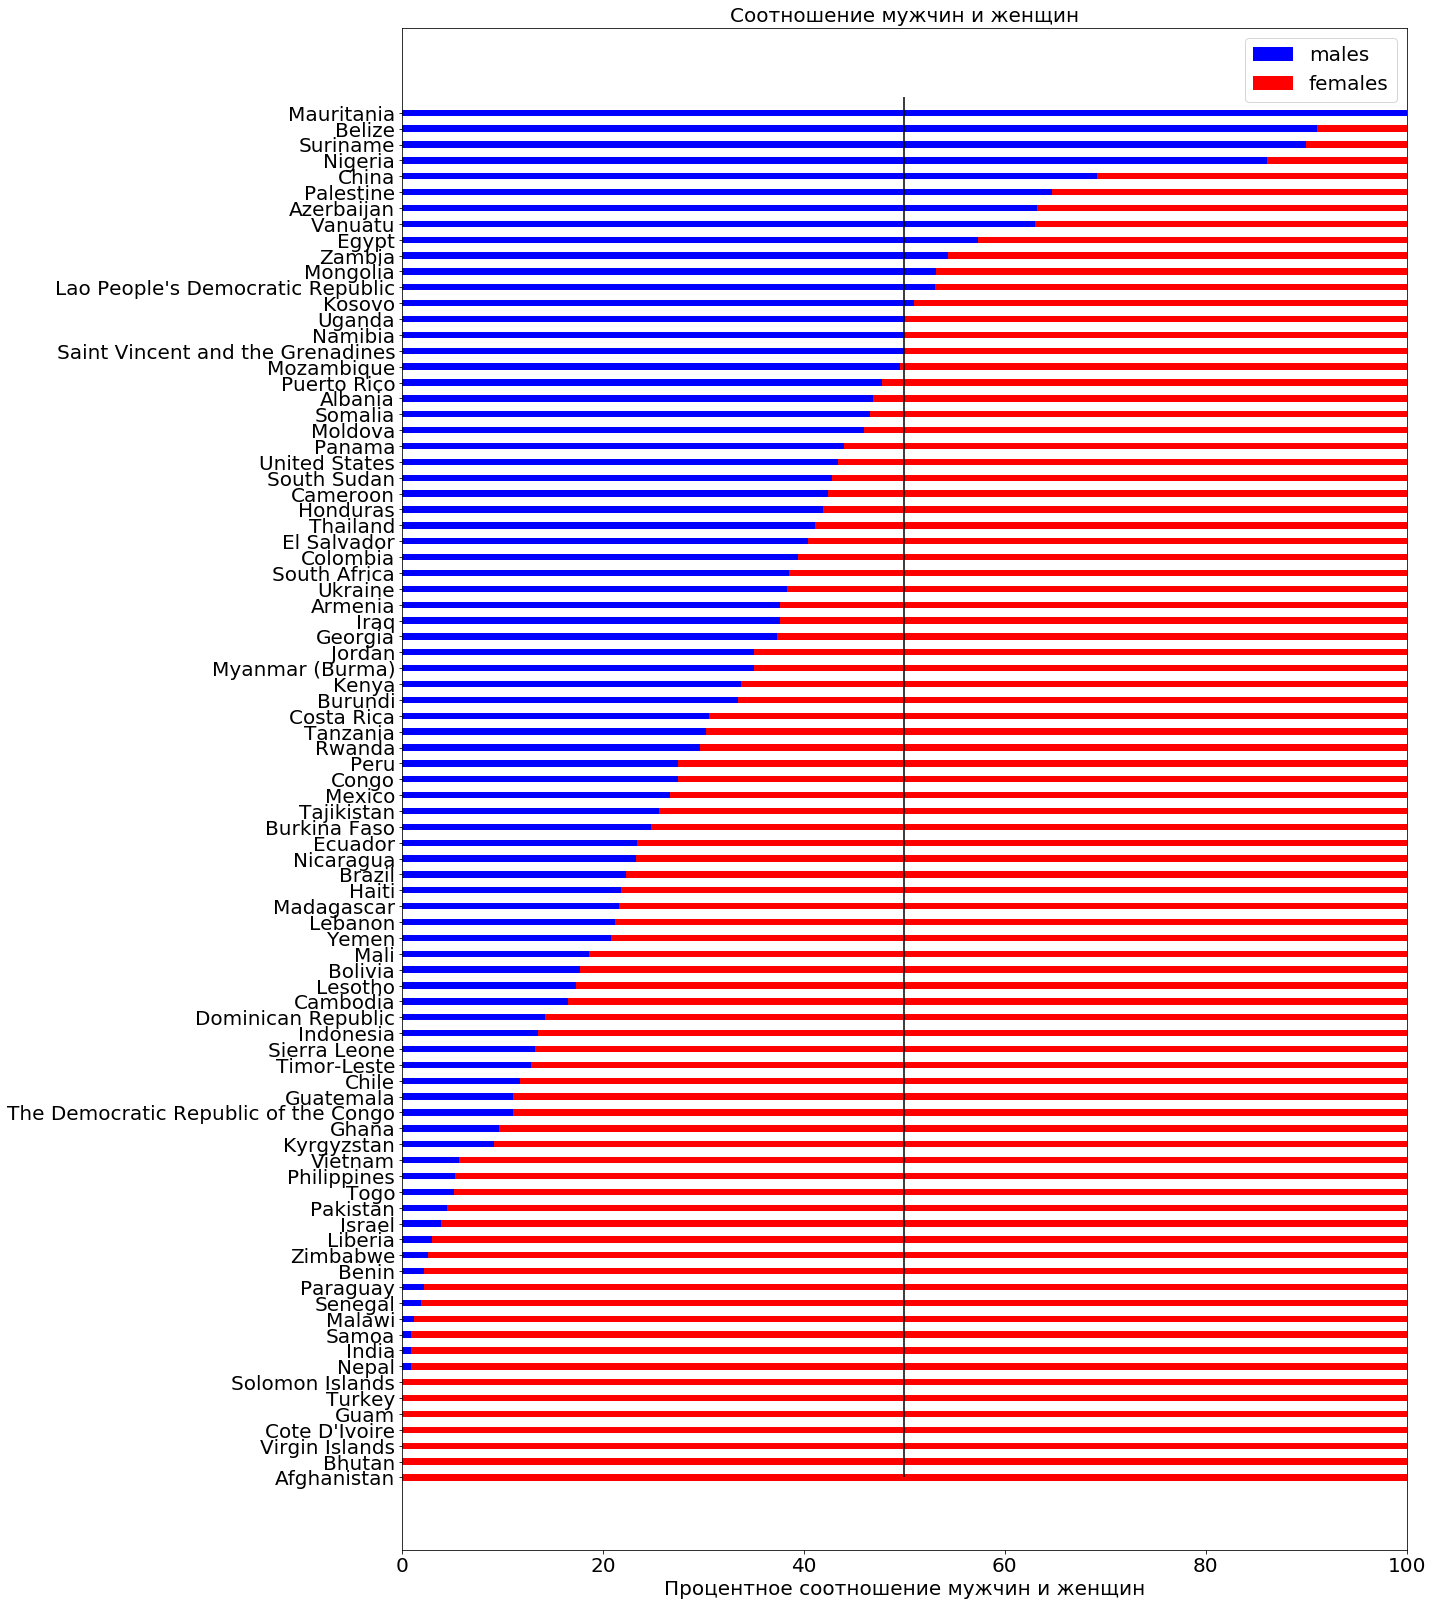

In [11]:
temp_df = grouped_loans_df[grouped_loans_df.columns[:4]].sort_values('males_share', ascending=False)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18, 28)

y_barh = temp_df.shape[0]
height = 0.4

p_males = plt.barh(range(y_barh), temp_df[::-1].males_share.values, height, color = 'b')
p_females = plt.barh(range(y_barh), [100]*temp_df[::-1].shape[0], height, left=temp_df[::-1].males_share.values, color = 'r')

plt.xlim([0,100])
plt.xlabel('Процентное соотношение мужчин и женщин', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(range(y_barh), temp_df[::-1].index, fontsize=20)
plt.legend((p_males[0], p_females[0]), ('males', 'females'), fontsize=20)
plt.title('Соотношение мужчин и женщин',  fontsize=20);
plt.vlines(50, 0, y_barh);

In [12]:
# Страны расположены по порядку убывания доли мужчин

temp_df

,females_per_country,males_per_country,males_share,females_share
country,,,,
Mauritania,0,1,100.000000,0.000000
Belize,11,112,91.056911,8.943089
Suriname,22,197,89.954338,10.045662
Nigeria,1438,8914,86.108964,13.891036
China,41,92,69.172932,30.827068
Palestine,2876,5276,64.720314,35.279686
Azerbaijan,703,1207,63.193717,36.806283
Vanuatu,17,29,63.043478,36.956522
Egypt,699,940,57.352044,42.647956


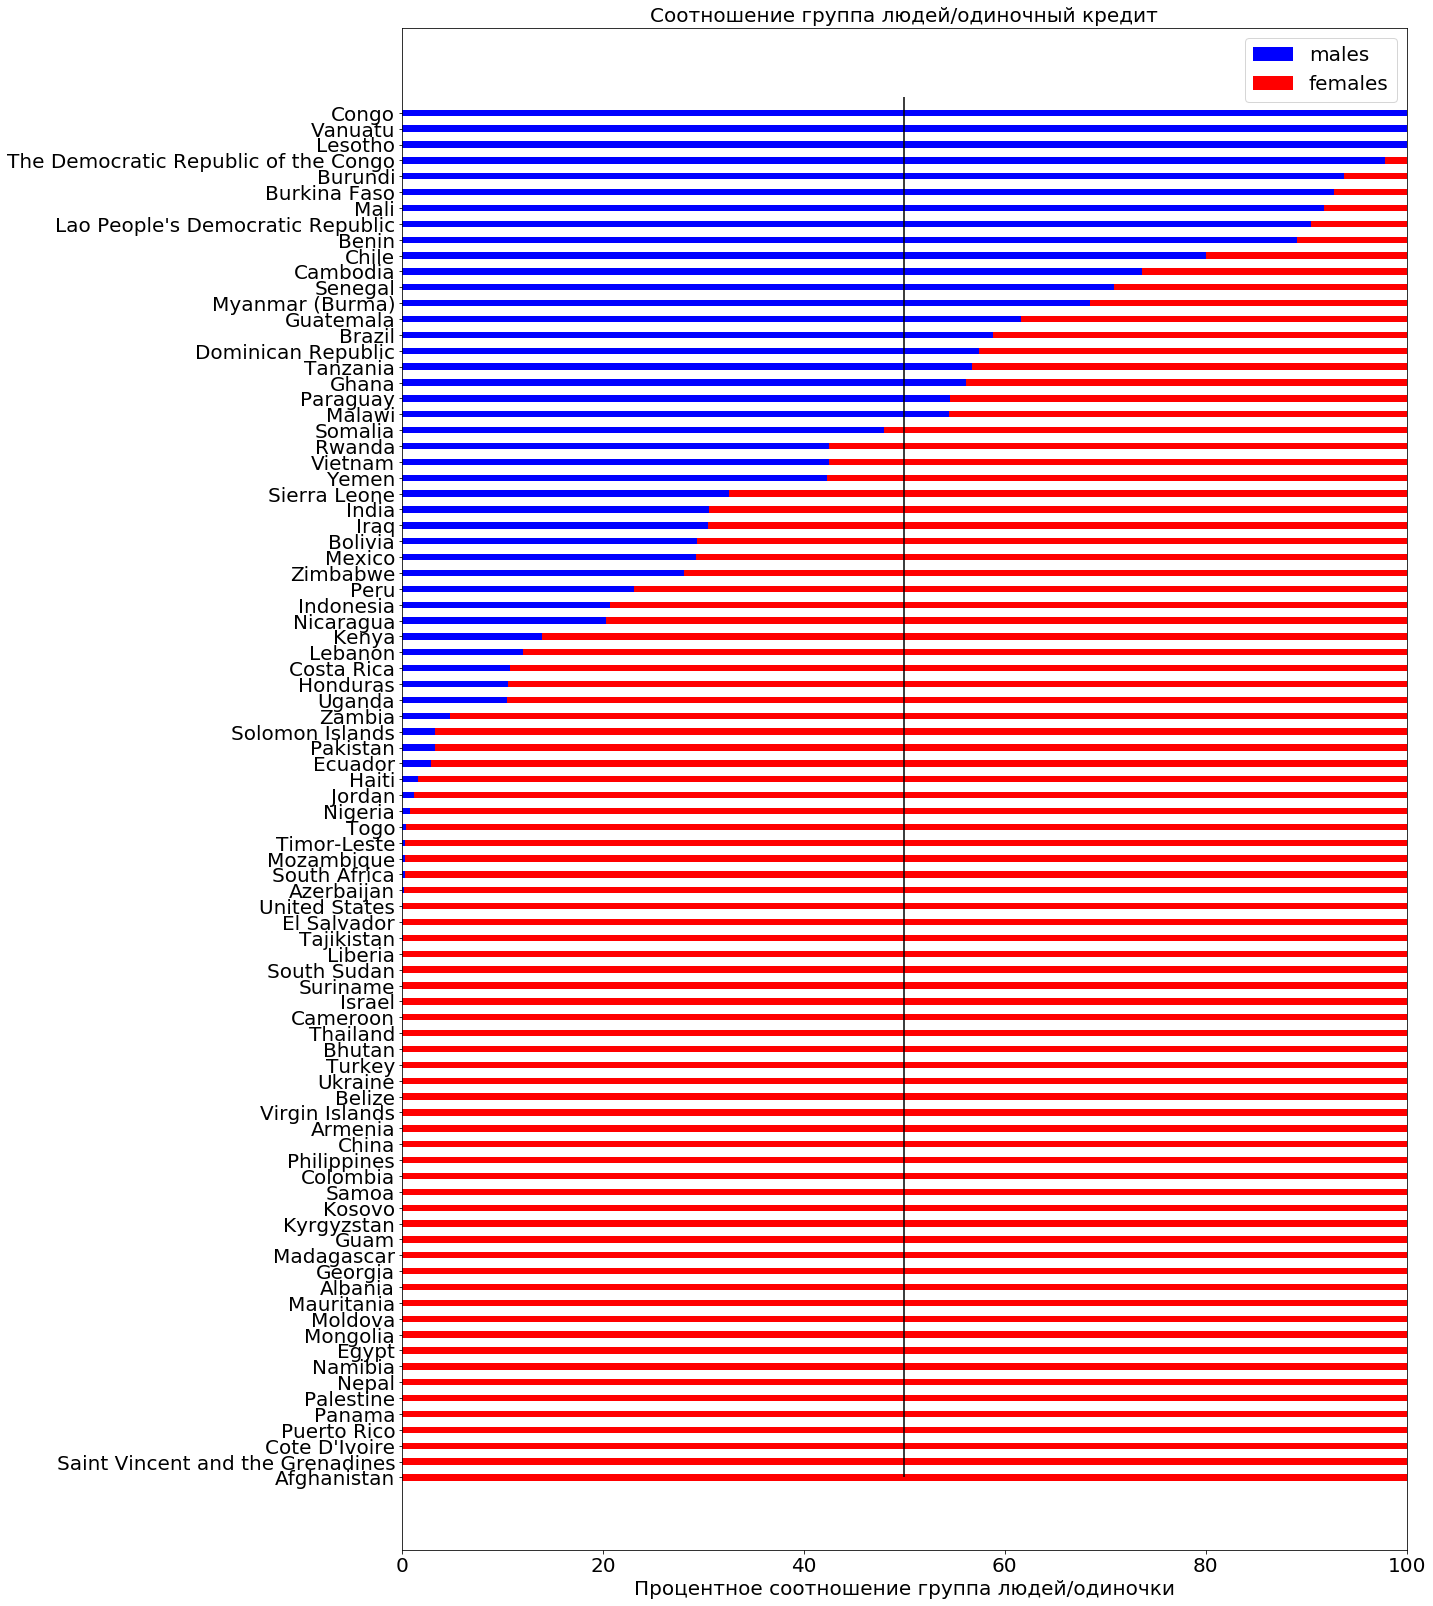

In [13]:
temp_df = grouped_loans_df[grouped_loans_df.columns[4:8]].sort_values('group_share', ascending=False)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18, 28)

y_barh = temp_df.shape[0]
height = 0.4

p_males = plt.barh(range(y_barh), temp_df[::-1].group_share.values, height, color = 'b')
p_females = plt.barh(range(y_barh), [100]*temp_df[::-1].shape[0], height, left=temp_df[::-1].group_share.values, color = 'r')

plt.xlim([0,100])
plt.xlabel('Процентное соотношение группа людей/одиночки', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(range(y_barh), temp_df[::-1].index, fontsize=20)
plt.legend((p_males[0], p_females[0]), ('males', 'females'), fontsize=20)
plt.title('Соотношение группа людей/одиночный кредит',  fontsize=20);
plt.vlines(50, 0, y_barh);

In [14]:
# Страны расположены по порядку убывания доли групп людей в запросах на кредит

temp_df

,grouped_per_country,nogrouped_per_country,group_share,nogroup_share
country,,,,
Congo,128,0,100.000000,0.000000
Vanuatu,4,0,100.000000,0.000000
Lesotho,422,0,100.000000,0.000000
The Democratic Republic of the Congo,3008,65,97.884803,2.115197
Burundi,825,55,93.750000,6.250000
Burkina Faso,2282,178,92.764228,7.235772
Mali,6095,544,91.805995,8.194005
Lao People's Democratic Republic,1344,142,90.444145,9.555855
Benin,443,54,89.134809,10.865191


Изучите несколько займов с очень большими суммами. Что можно сказать о назначении этих заявок? В каких странах они оформлены? Каков гендерный состав заявителей? (п. 2.4.2.)

In [15]:
heavy_loans_df = loans_df[loans_df['funded_amount'] >= 50000].sort_values('funded_amount', ascending=False).head(33)

In [16]:
# Расположил отрасли по количеству больших займов (больше или равно 50000) в порядке снижения количества

heavy_loans_df.groupby(['activity', 'sector'])['sector'].count().sort_values(ascending=False)

activity                   sector       
Agriculture                Agriculture      13
Renewable Energy Products  Retail            8
Health                     Health            3
Water Distribution         Services          1
Poultry                    Agriculture       1
Higher education costs     Education         1
Goods Distribution         Wholesale         1
Furniture Making           Manufacturing     1
Farming                    Agriculture       1
Electronics Sales          Retail            1
Construction               Construction      1
Clothing                   Clothing          1
Name: sector, dtype: int64

In [17]:
# Расположил страны по количеству больших займов (больше или равно 50000) в порядке снижения количества

heavy_loans_df.groupby('country')['country'].count().sort_values(ascending=False)

country
Kenya            7
Ghana            3
Haiti            2
Uganda           2
Tanzania         2
Peru             2
Mexico           2
Zimbabwe         1
Benin            1
Cote D'Ivoire    1
Ecuador          1
Guatemala        1
Madagascar       1
Indonesia        1
Zambia           1
Malawi           1
Mozambique       1
Rwanda           1
South Sudan      1
Albania          1
Name: country, dtype: int64

In [18]:
# Мужчин ровно вдвое больше, чем женщин в числе участников займов больших сумм денег

heavy_loans_df.agg({'males': 'sum', 'females': 'sum'})

males      26
females    13
dtype: int64

In [19]:
loans_df.agg({'males': 'sum', 'females': 'sum'})

males       274904
females    1071308
dtype: int64

In [20]:
# При займе крупных сумм соотношение мужчин к женщинам выше, чем по среднему займу.

print(f"Cоотношение мужчин к женщинам в общем случае               = \
{loans_df.agg({'males': 'sum', 'females': 'sum'})['males']/loans_df.agg({'males': 'sum', 'females': 'sum'})['females']}\n\
Соотношение мужчин к женщинам при займе больших сумм денег = \
{heavy_loans_df.agg({'males': 'sum', 'females': 'sum'})['males']/heavy_loans_df.agg({'males': 'sum', 'females': 'sum'})['females']}")

Cоотношение мужчин к женщинам в общем случае               = 0.25660594338882936
Соотношение мужчин к женщинам при займе больших сумм денег = 2.0


Попробуйте найти связь между странами (регионами), полом заёмщика и суммой заявки. Какие выводы можно сделать из этих данных? (п. 2.4.3.)

In [21]:
pd.options.display.max_rows = 78

In [22]:
# Сделаем набор данных, чтобы посмотреть связи между странами, полом и суммой заявки. Возьмем только страны, где
# взяли > 10 займов

genders_summs_loans_df = loans_df.groupby('country').agg({'males': ['sum', 'mean'], 
                                                          'females': ['sum', 'mean'], 
                                                          'funded_amount': ['mean', 'median', 'max', 'min', 'count']})
genders_summs_loans_df.columns = ['males_count', 'males_mean', 
                                  'females_count', 'females_mean', 'mean_funded', 'median_funded', 
                                  'max_funded', 'min_funded', 'loans_count']
genders_summs_loans_df.insert(4, 'male/female ratio', genders_summs_loans_df['males_count'] / 
                              genders_summs_loans_df['females_count'])
genders_summs_loans_df.insert(5, 'mean_of_lenders', (genders_summs_loans_df['males_count'] + 
                                                     genders_summs_loans_df['females_count']) / 
                              genders_summs_loans_df['loans_count'])
genders_summs_loans_df = genders_summs_loans_df[genders_summs_loans_df['loans_count'] > 10]

In [23]:
# Расположим страны по соотношению количества заемщиков мужчин/женщин
# Большинство стран распределились на "мужские" и "женские". Поровну оказалось у "Saint Vincent and the Grenadines",
# есть как крайне мужские (Бейлиз и Суринам) и крайне женские (Турция и Соломоновы острова)

genders_summs_loans_df = genders_summs_loans_df.sort_values('male/female ratio')
genders_summs_loans_df

,males_count,males_mean,females_count,females_mean,male/female ratio,mean_of_lenders,mean_funded,median_funded,max_funded,min_funded,loans_count
country,,,,,,,,,,,
Turkey,0,0.000000,1701,0.998826,0.000000,0.998826,436.655901,375.0,12375.0,50.0,1703
Solomon Islands,0,0.000000,632,1.140794,0.000000,1.140794,891.471119,850.0,3600.0,0.0,554
Nepal,6,0.008368,711,0.991632,0.008439,1.000000,429.044630,375.0,13875.0,50.0,717
India,253,0.022515,27630,2.458841,0.009157,2.481356,575.496129,325.0,12925.0,0.0,11237
Samoa,68,0.009194,7304,0.987561,0.009310,0.996755,762.821120,600.0,6975.0,0.0,7396
Malawi,148,0.112121,12240,9.272727,0.012092,9.384848,1221.590909,1150.0,50000.0,0.0,1320
Senegal,625,0.191190,31919,9.764148,0.019581,9.955338,2086.165494,1850.0,6150.0,0.0,3269
Paraguay,2527,0.212299,116633,9.798622,0.021666,10.010922,2471.032513,2400.0,16275.0,0.0,11903
Benin,50,0.100604,2295,4.617706,0.021786,4.718310,1039.889336,625.0,50000.0,200.0,497


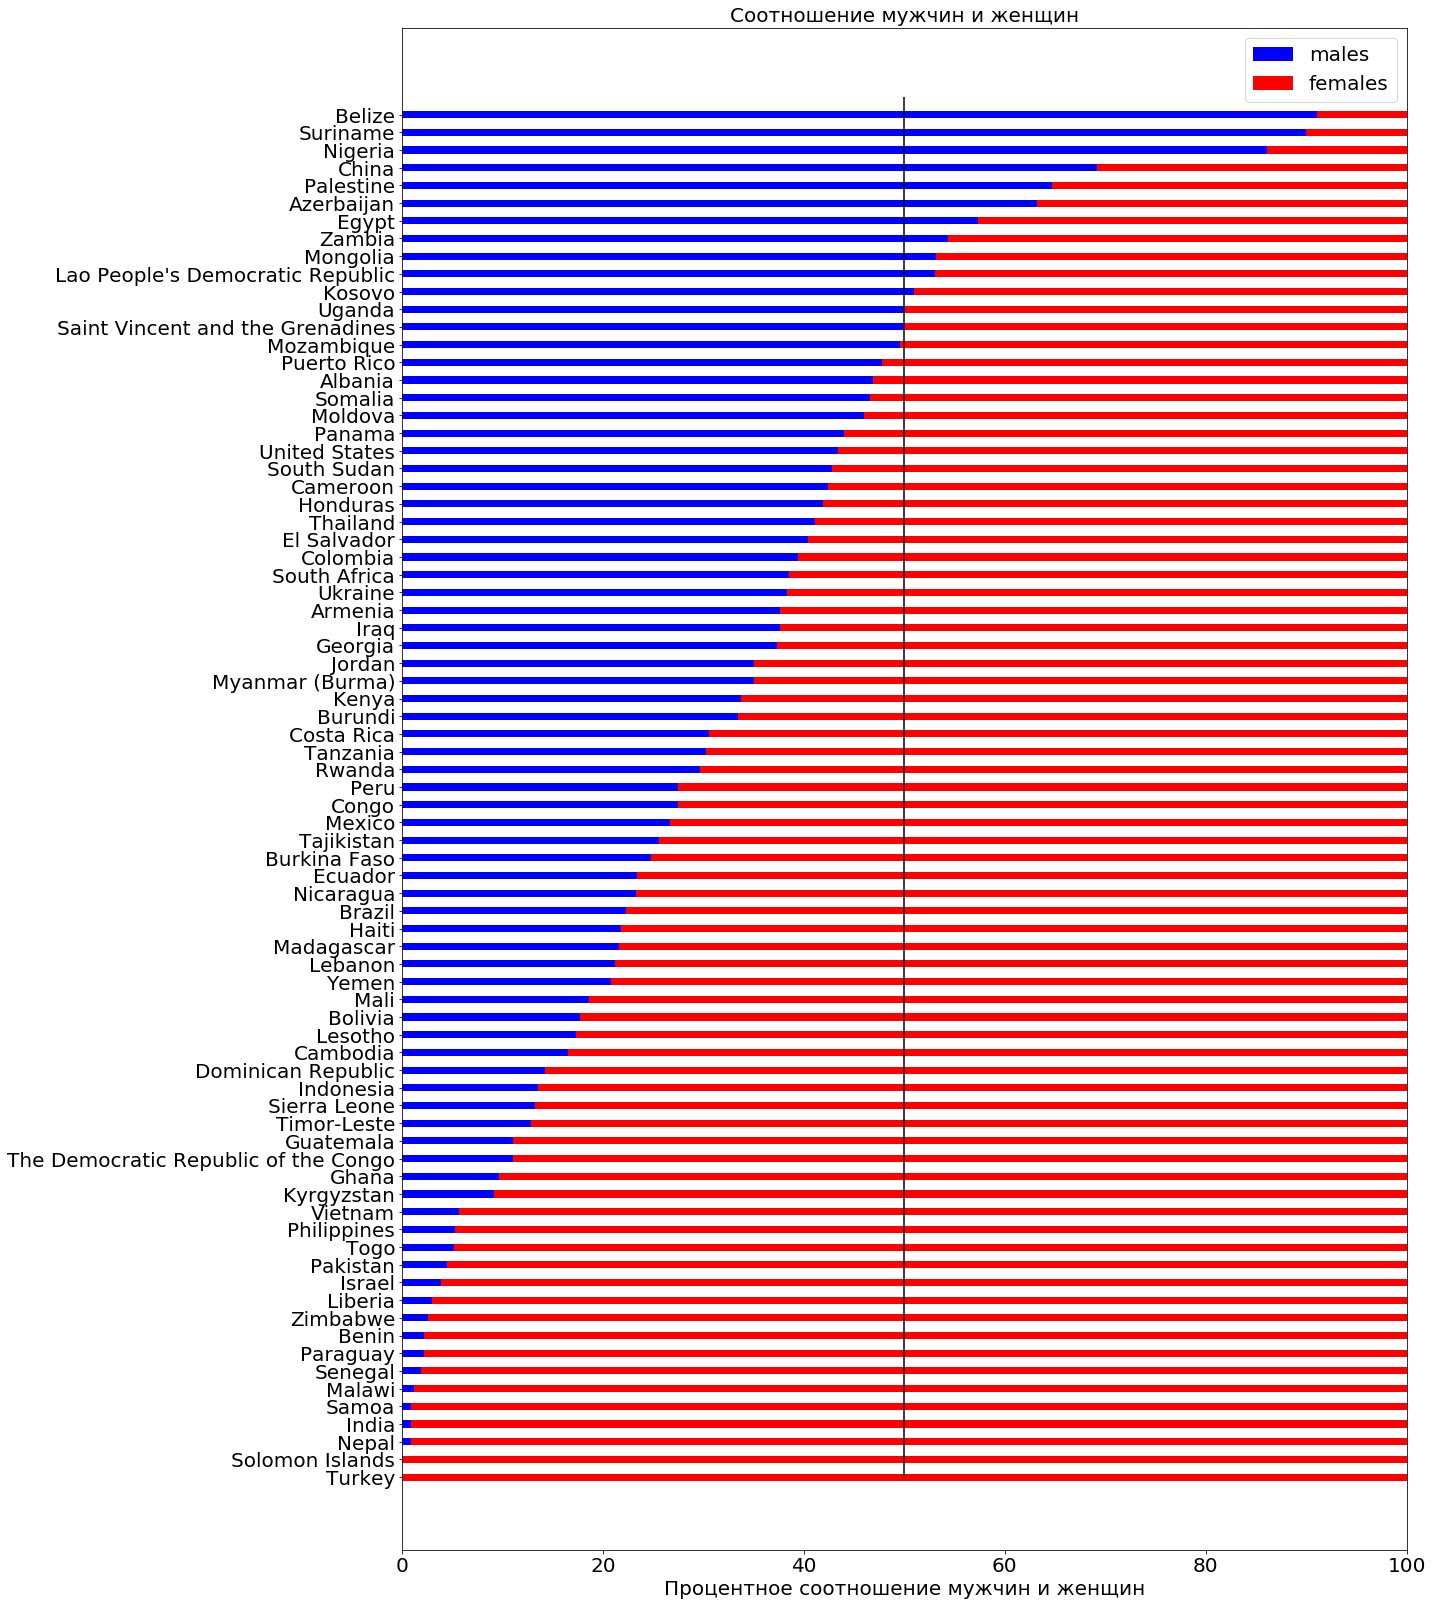

In [24]:
# Вертикальная черта - равное соотношение мужчин и женщин

genders_summs_loans_df['genders_count'] = genders_summs_loans_df.males_count + genders_summs_loans_df.females_count
genders_summs_loans_df['males_share'] = 100 * genders_summs_loans_df.males_count / genders_summs_loans_df.genders_count
genders_summs_loans_df['females_share'] = 100 * genders_summs_loans_df.females_count / genders_summs_loans_df.genders_count

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18, 28)

y_barh = genders_summs_loans_df.shape[0]
height = 0.4

p_males = plt.barh(range(y_barh), genders_summs_loans_df.males_share.values, height, color = 'b')
p_females = plt.barh(range(y_barh), [100]*genders_summs_loans_df.shape[0], height, left=genders_summs_loans_df.males_share.values, color = 'r')

plt.xlim([0,100])
plt.xlabel('Процентное соотношение мужчин и женщин', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(range(y_barh), genders_summs_loans_df.index, fontsize=20)
plt.legend((p_males[0], p_females[0]), ('males', 'females'), fontsize=20)
plt.title('Соотношение мужчин и женщин',  fontsize=20);
plt.vlines(50, 0, genders_summs_loans_df.shape[0]);

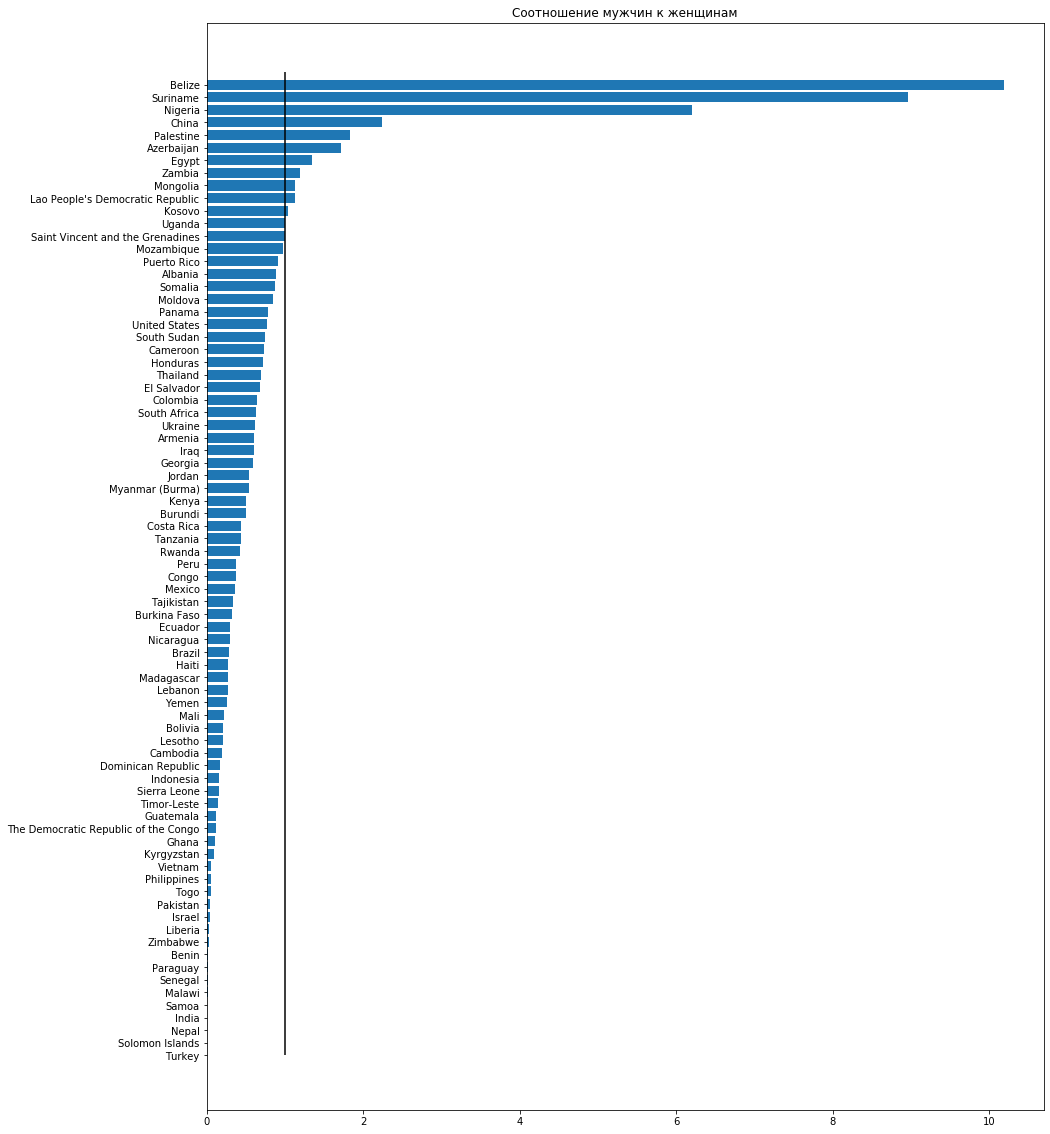

In [25]:
# Еще один график с соотношением.
# Вертикальная линия - равное соотношение мужчин и женщин

x = genders_summs_loans_df.sort_values('male/female ratio').index
y = genders_summs_loans_df.sort_values('male/female ratio')['male/female ratio']

plt.figure(figsize=(15,20))
h = plt.barh(x, y, label=x)
plt.vlines(1, 0, np.ma.count(y))
plt.title('Соотношение мужчин к женщинам');

In [26]:
# Мужчины проигрывают женщинам по валовому, среднему и медианному займу.

temp_df = genders_summs_loans_df.agg({'males_count': ['sum', 'mean', 'median'], 'females_count': ['sum', 'mean', 'median']})
temp_df['females_count'] = temp_df['females_count'].map(lambda x: round(x, 3))
temp_df

,males_count,females_count
sum,274854.000000,1071160.000
mean,3523.769231,13732.821
median,942.500000,3562.000


In [27]:
# Отсортируем страны по средней заявке в порядке убывания

genders_summs_loans_df.sort_values('mean_funded', ascending=False)

,males_count,males_mean,females_count,females_mean,male/female ratio,mean_of_lenders,mean_funded,median_funded,max_funded,min_funded,loans_count,genders_count,males_share,females_share
country,,,,,,,,,,,,,,
Congo,345,2.695312,910,7.109375,0.379121,9.804688,6142.578125,6025.0,9925.0,1850.0,128,1255,27.490040,72.509960
Puerto Rico,32,0.470588,35,0.514706,0.914286,0.985294,4409.191176,5000.0,10000.0,0.0,68,67,47.761194,52.238806
Dominican Republic,375,0.756048,2264,4.564516,0.165636,5.320565,4200.604839,3725.0,11575.0,50.0,496,2639,14.209928,85.790072
United States,2580,0.423437,3360,0.551452,0.767857,0.974889,3800.843591,3000.0,10000.0,0.0,6093,5940,43.434343,56.565657
Israel,7,0.036842,175,0.921053,0.040000,0.957895,3786.578947,3887.5,7825.0,1300.0,190,182,3.846154,96.153846
The Democratic Republic of the Congo,5084,1.654409,40893,13.307192,0.124324,14.961601,3586.161731,3100.0,10000.0,0.0,3073,45977,11.057703,88.942297
Saint Vincent and the Grenadines,8,0.500000,8,0.500000,1.000000,1.000000,3076.562500,3687.5,4000.0,750.0,16,16,50.000000,50.000000
Somalia,150,2.000000,172,2.293333,0.872093,4.293333,3011.666667,1500.0,8000.0,300.0,75,322,46.583851,53.416149
Burundi,5874,6.675000,11697,13.292045,0.502180,19.967045,2907.443182,2737.5,6000.0,200.0,880,17571,33.430084,66.569916


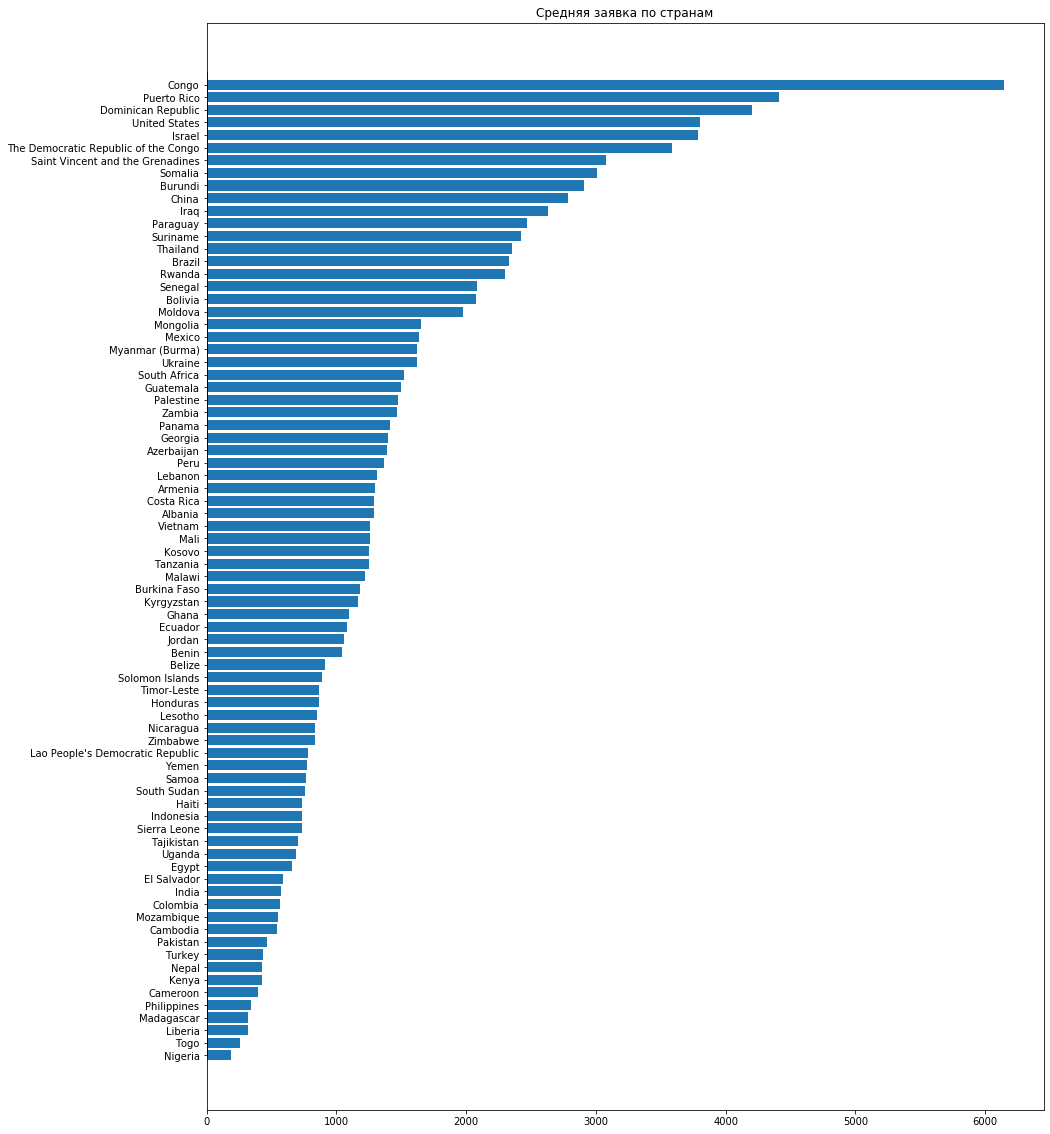

In [28]:
x = genders_summs_loans_df.sort_values('mean_funded').index
y = genders_summs_loans_df.sort_values('mean_funded')['mean_funded']

plt.figure(figsize=(15,20))
h = plt.barh(x, y, label=x)
plt.vlines(1, 0, np.ma.count(y))
plt.title('Средняя заявка по странам');

In [29]:
# Есть страны, где никому не отказывают, т.е. даже при большом количестве запросов там нет нулевых сумм займа.

genders_summs_loans_df.query('min_funded != 0')

,males_count,males_mean,females_count,females_mean,male/female ratio,mean_of_lenders,mean_funded,median_funded,max_funded,min_funded,loans_count,genders_count,males_share,females_share
country,,,,,,,,,,,,,,
Turkey,0,0.000000,1701,0.998826,0.000000,0.998826,436.655901,375.0,12375.0,50.0,1703,1701,0.000000,100.000000
Nepal,6,0.008368,711,0.991632,0.008439,1.000000,429.044630,375.0,13875.0,50.0,717,717,0.836820,99.163180
Benin,50,0.100604,2295,4.617706,0.021786,4.718310,1039.889336,625.0,50000.0,200.0,497,2345,2.132196,97.867804
Israel,7,0.036842,175,0.921053,0.040000,0.957895,3786.578947,3887.5,7825.0,1300.0,190,182,3.846154,96.153846
Kyrgyzstan,526,0.091098,5247,0.908729,0.100248,0.999827,1165.318670,1012.5,8000.0,75.0,5774,5773,9.111381,90.888619
Timor-Leste,347,0.128996,2357,0.876208,0.147221,1.005204,865.018587,800.0,10000.0,25.0,2690,2704,12.832840,87.167160
Dominican Republic,375,0.756048,2264,4.564516,0.165636,5.320565,4200.604839,3725.0,11575.0,50.0,496,2639,14.209928,85.790072
Lesotho,645,1.528436,3081,7.300948,0.209348,8.829384,851.954976,825.0,2400.0,425.0,422,3726,17.310789,82.689211
Brazil,187,0.658451,651,2.292254,0.287250,2.950704,2327.552817,2100.0,30000.0,200.0,284,838,22.315036,77.684964


## 4.2. Домашняя работа
***

Расширьте наш отчёт исследованием следующих вопросов:

- Зависимость пола заёмщика от региона планеты, сектора экономики.
- Влияние такого атрибута займа, как **Количество кредиторов** (lender_count), на суммы и сроки займов.
- Влияние показателя **MPI** (многомерный индекс бедности) в разных странах на суммы займов и сроки погашения.
- Зависимости таких метрик, как «Сумма займа», «Срок займа», «Время финансирования заявки», «Ежемесячный платёж», в разрезе **макрорегионов**.

Зависимость пола заёмщика от региона планеты, сектора экономики.

In [30]:
loans_regions_df = loans_df.merge(regions_df, on = ['country', 'region'])

In [31]:
loans_regions_df.head()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,...,group,females,males,LocationName,ISO,world_region,MPI,geo,lat,lon
0,653359,600.0,600.0,Machinery Rental,Services,to invest in working capital and to maintain g...,NI,Nicaragua,Leon,NIO,...,0,1,0,"Leon, Nicaragua",NIC,Latin America and Caribbean,0.031,"(28.3998551, 83.6895693)",28.399855,83.689569
1,653373,1000.0,1000.0,Grocery Store,Food,to invest in working capital and to provide hi...,NI,Nicaragua,Leon,NIO,...,0,0,1,"Leon, Nicaragua",NIC,Latin America and Caribbean,0.031,"(28.3998551, 83.6895693)",28.399855,83.689569
2,653364,250.0,250.0,Fuel/Firewood,Retail,to buy firewood to offer to her customers,NI,Nicaragua,Leon,NIO,...,0,1,0,"Leon, Nicaragua",NIC,Latin America and Caribbean,0.031,"(28.3998551, 83.6895693)",28.399855,83.689569
3,653367,175.0,175.0,Food Market,Food,to invest in working capital and stock up her ...,NI,Nicaragua,Leon,NIO,...,0,1,0,"Leon, Nicaragua",NIC,Latin America and Caribbean,0.031,"(28.3998551, 83.6895693)",28.399855,83.689569
4,653396,800.0,800.0,Clothing Sales,Clothing,to invest in working capital to stock their bu...,NI,Nicaragua,Leon,NIO,...,1,3,0,"Leon, Nicaragua",NIC,Latin America and Caribbean,0.031,"(28.3998551, 83.6895693)",28.399855,83.689569


In [32]:
# Женщины более склонны к коллективным займам, чем мужчины независимо от региона
# Есть регионы, где люди более склонны к сотрудничеству, и наоборот, где более склонны к индивидуальной работе
# От региона к региону склонность к сотрудничеству у мужчин и женщин растет и падает вместе. Но не пропорционально.
# Африка - особый регион, здесь меньше разница в заимствованиях у мужчин и женщин и больше коллективизм среди мужчин.

temp_df = loans_regions_df.groupby('world_region').agg({'males': ['sum', 'mean'], 'females': ['sum', 'mean']})
temp_df.columns = ['males_sum', 'males_mean', 'females_sum', 'females_mean']
temp_df['male/female ratio'] = temp_df['males_sum'] / temp_df['females_sum']
temp_df

,males_sum,males_mean,females_sum,females_mean,male/female ratio
world_region,,,,,
Arab States,422,0.578082,1067,1.461644,0.395501
East Asia and the Pacific,6983,0.572096,24769,2.029248,0.281925
Europe and Central Asia,558,0.295238,1271,0.672487,0.439024
Latin America and Caribbean,11089,0.513285,29864,1.382337,0.371317
South Asia,6,0.089552,20,0.298507,0.300000
Sub-Saharan Africa,10302,0.656178,14672,0.934522,0.702154


In [33]:
# Отрасли отсортированы от более мужских к женским, параметр "male/female ratio" - соотношение мужчин к женщинам

temp_df = loans_regions_df.groupby('sector').agg({'males': ['sum', 'mean'], 'females': ['sum', 'mean']})
temp_df.columns = ['males_sum', 'males_mean', 'females_sum', 'females_mean']
temp_df['male/female ratio'] = temp_df['males_sum'] / temp_df['females_sum']
temp_df.sort_values('male/female ratio', ascending=False)

,males_sum,males_mean,females_sum,females_mean,male/female ratio
sector,,,,,
Entertainment,39,0.975000,23,0.575000,1.695652
Agriculture,9090,0.766183,5798,0.488705,1.567782
Transportation,559,0.952300,384,0.654174,1.455729
Education,2186,0.628522,1688,0.485336,1.295024
Manufacturing,232,0.753247,280,0.909091,0.828571
Housing,1548,0.471520,2280,0.694487,0.678947
Construction,297,0.651316,455,0.997807,0.652747
Health,473,0.442470,737,0.689429,0.641791
Personal Use,9180,0.722380,23416,1.842619,0.392040


Влияние такого атрибута займа, как Количество кредиторов (lender_count), на суммы и сроки займов.

In [34]:
loans_df.head()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,...,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date,genders,group,females,males
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,...,12.0,12,NaN,female,irregular,2014-01-01,{'female': 1},0,1,0
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,...,11.0,14,NaN,"female, female",irregular,2014-01-01,{'female': 2},1,2,0
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,...,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01,{'female': 1},0,1,0
3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variet...,PK,Pakistan,Lahore,PKR,...,11.0,8,NaN,female,irregular,2014-01-01,{'female': 1},0,1,0
4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,...,14.0,16,NaN,female,monthly,2014-01-01,{'female': 1},0,1,0


In [35]:
# Максимальный срок займа = 2986 / 12 = 248,83 года

temp_df = loans_df.groupby('lender_count')['funded_amount'].mean()
temp_df.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1605, 1606, 1609, 1626, 1671, 1688, 1689, 1706, 1765, 2986],
           dtype='int64', name='lender_count', length=503)

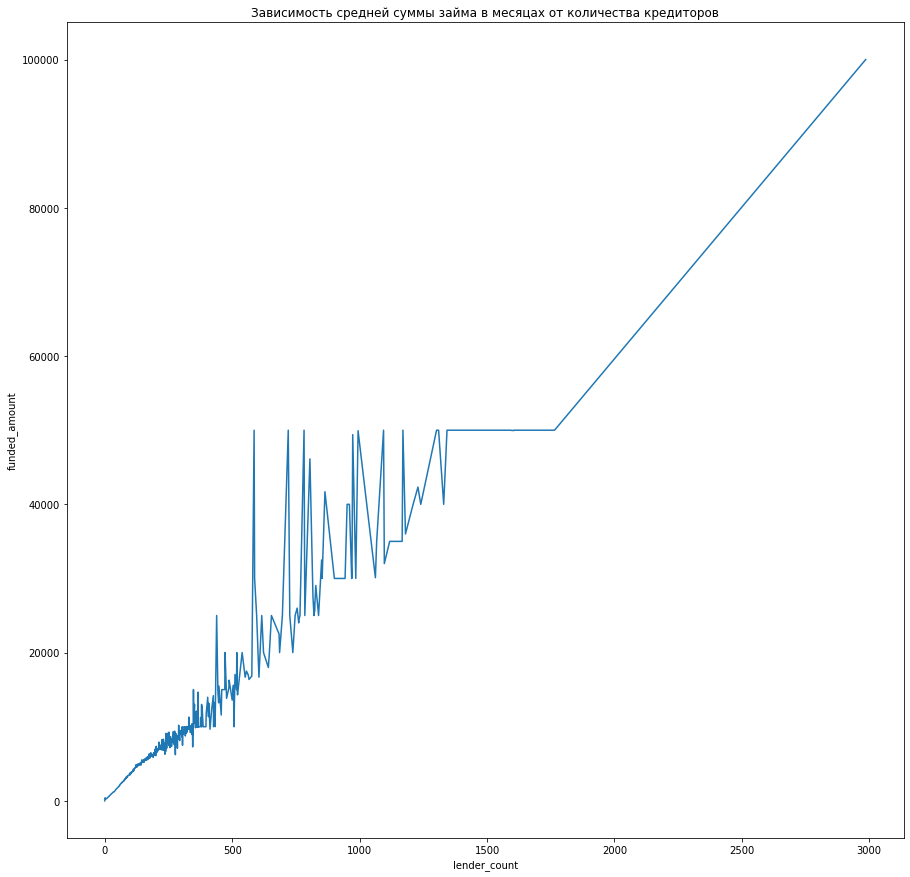

In [36]:
# Чем больше кредиторов, тем больше средняя сумма кредита

plt.figure(figsize=(15, 15))
plt.title('Зависимость средней суммы займа в месяцах от количества кредиторов')
plt.ylabel('funded_amount')
plt.xlabel('lender_count')
plt.plot(temp_df.index, temp_df.values);

In [37]:
# Максимальное количество кредиторов = 2986 человек

temp_df = loans_df.groupby('lender_count')['term_in_months'].mean()
temp_df.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1605, 1606, 1609, 1626, 1671, 1688, 1689, 1706, 1765, 2986],
           dtype='int64', name='lender_count', length=503)

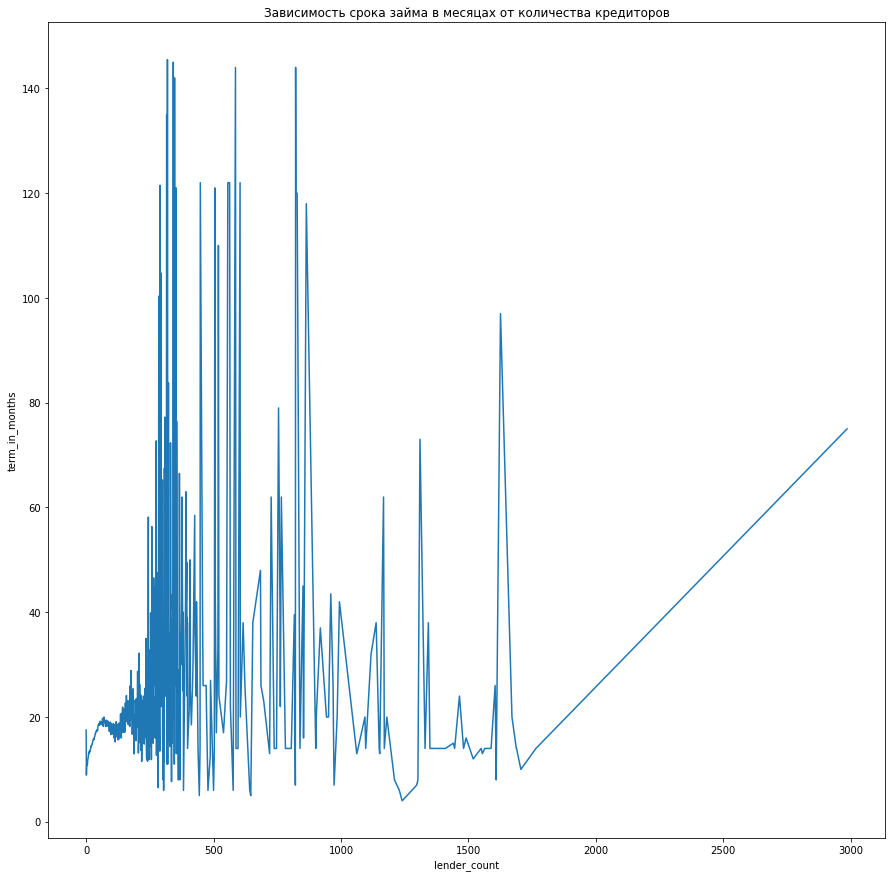

In [38]:
# Есть небольшое снижение длительности кредита при увеличении количества кредиторов.

plt.figure(figsize=(15, 15))
plt.title('Зависимость срока займа в месяцах от количества кредиторов')
plt.ylabel('term_in_months')
plt.xlabel('lender_count')
plt.plot(temp_df.index, temp_df.values);

Влияние показателя MPI (многомерный индекс бедности) в разных странах на суммы займов и сроки погашения.

In [39]:
temp_df = loans_regions_df.groupby('MPI')['funded_amount'].mean()

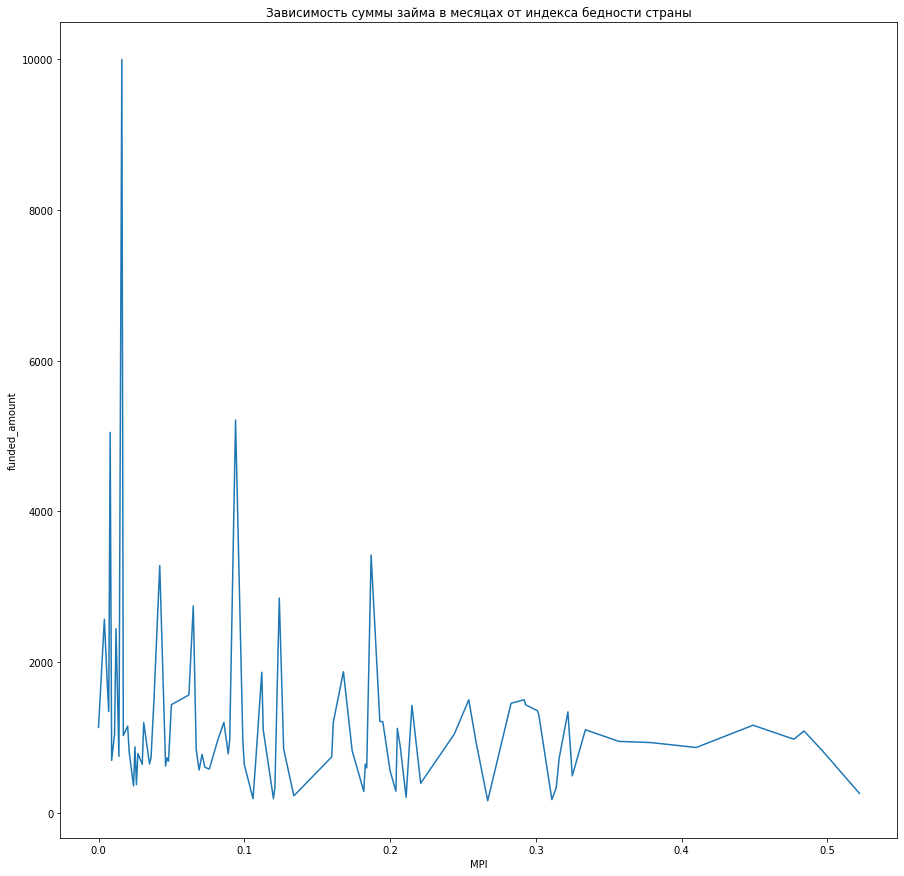

In [40]:
# С увеличением индекса бедности суммы займов снижаются

plt.figure(figsize=(15, 15))
plt.title('Зависимость суммы займа в месяцах от индекса бедности страны')
plt.ylabel('funded_amount')
plt.xlabel('MPI')
plt.plot(temp_df.index, temp_df.values);

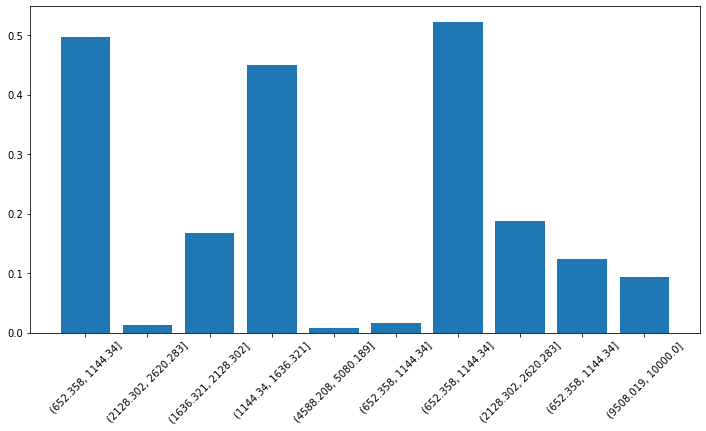

In [41]:
cuts = pd.cut(temp_df.values, bins=20)

fig, ax = plt.subplots()
ax.bar(cuts.astype('str'), temp_df.index)
fig.set_figwidth(12)
fig.set_figheight(6)
ax.set_xticklabels(cuts.astype('str'), rotation=45);

In [42]:
temp_df = loans_regions_df.groupby('MPI')['term_in_months'].mean()

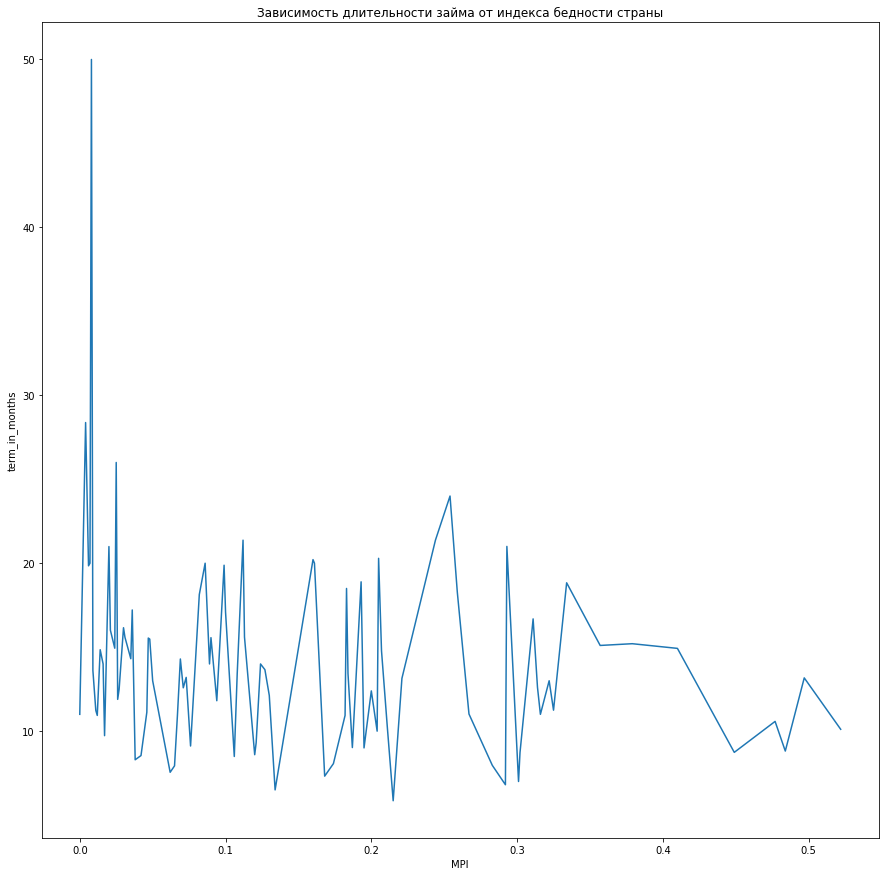

In [43]:
# Не уверен, правильно ли понял, что сроки погашения - это term_in_months
# При увеличении коэффициента MPI снижается средний займ

plt.figure(figsize=(15, 15))
plt.title('Зависимость длительности займа от индекса бедности страны')
plt.ylabel('term_in_months')
plt.xlabel('MPI')
plt.plot(temp_df.index, temp_df.values);

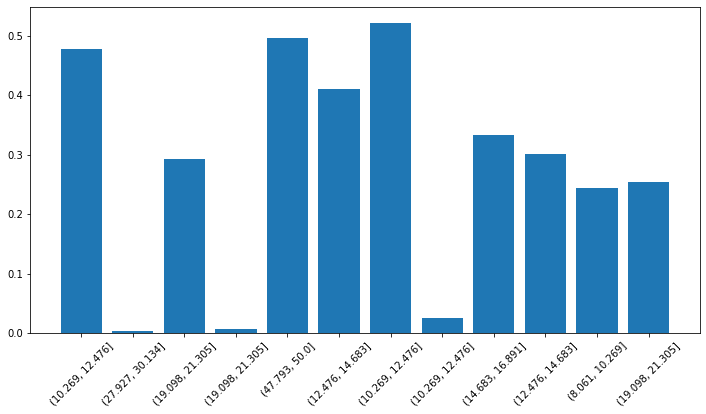

In [44]:
cuts = pd.cut(temp_df.values, bins=20)

fig, ax = plt.subplots()
ax.bar(cuts.astype('str'), temp_df.index)
fig.set_figwidth(12)
fig.set_figheight(6)
ax.set_xticklabels(cuts.astype('str'), rotation=45);

Зависимости таких метрик, как «Сумма займа», «Срок займа», «Время финансирования заявки», «Ежемесячный платёж», в разрезе макрорегионов.

In [45]:
loans_regions_df['financing_time'] = loans_regions_df['funded_time'] - loans_regions_df['posted_time']
loans_regions_df['financing_time'] = loans_regions_df['financing_time'].dt.days
temp_df = loans_regions_df.groupby('world_region').agg({'funded_amount': ['count', 'mean', 'median'], \
                                                        'term_in_months': ['count', 'mean', 'median'], \
                                                        'financing_time': ['count', 'mean', 'median']})
temp_df.columns = ['funded_count', 'funded_mean', 'funded_median', 'months_count', 'months_mean', \
                   'months_median', 'time_count', 'time_mean', 'time_median']

In [46]:
# В восточной азии и Африке большая разница между медианным и средним значением суммы кредита (более чем в 2 раза)
# Расположил регионы по убыванию средней суммы кредита
# Лидеры и аутсайдеры среди регионов одни и те же по всем параметрам:
#                         в лидерах - южная азия, в аутсайдерах - восточная азия.

temp_df[temp_df.columns[:3]].sort_values('funded_mean', ascending=False)

,funded_count,funded_mean,funded_median
world_region,,,
South Asia,67,1747.388060,1500.0
Latin America and Caribbean,21604,1059.920617,750.0
Europe and Central Asia,1890,939.947090,800.0
Arab States,730,729.109589,575.0
Sub-Saharan Africa,15700,504.840764,175.0
East Asia and the Pacific,12206,433.766181,200.0


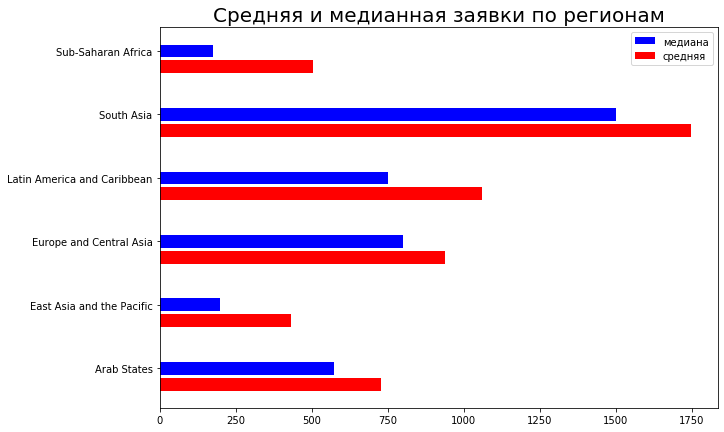

In [47]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes()

x = temp_df.index
xnum = range(temp_df.shape[0])
y = temp_df.funded_mean
y1 = temp_df.funded_median

mean_funded = plt.barh([i + 0.05 for i in xnum], [i for i in y], height=0.2, color='red')
median_funded = plt.barh([i + 0.3 for i in xnum], [i for i in y1], height=0.2, color='blue', tick_label=list(x))
plt.legend((median_funded, mean_funded), ('медиана', 'средняя'))
plt.title('Средняя и медианная заявки по регионам',  fontsize=20);

plt.show;

In [48]:
# Расположил регионы по убыванию среднего срока займа

temp_df[temp_df.columns[3:6]].sort_values('months_mean', ascending=False)

,months_count,months_mean,months_median
world_region,,,
South Asia,67,32.417910,43.0
Europe and Central Asia,1890,18.786243,14.0
Arab States,730,17.882192,14.0
Sub-Saharan Africa,15700,14.890064,14.0
Latin America and Caribbean,21604,13.475236,14.0
East Asia and the Pacific,12206,11.837949,8.0


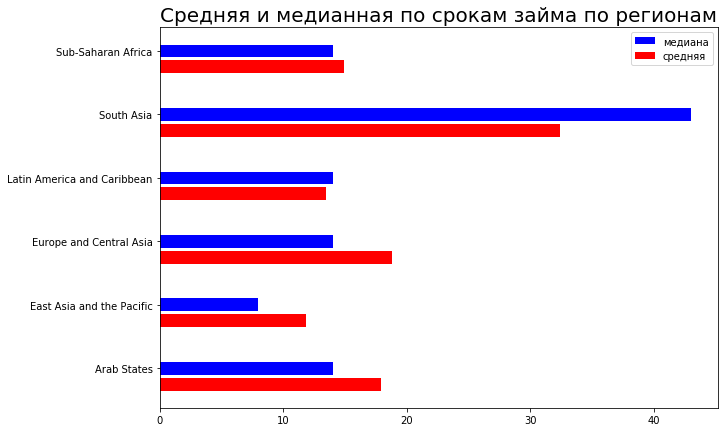

In [49]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes()

x = temp_df.index
xnum = range(temp_df.shape[0])
y = temp_df.months_mean
y1 = temp_df.months_median

months_mean = plt.barh([i + 0.05 for i in xnum], [i for i in y], height=0.2, color='red')
months_median = plt.barh([i + 0.3 for i in xnum], [i for i in y1], height=0.2, color='blue', tick_label=list(x))
plt.legend((months_median, months_mean), ('медиана', 'средняя'))
plt.title('Средняя и медианная по срокам займа по регионам',  fontsize=20);

plt.show;

In [50]:
# Расположил регионы по убыванию среднего времени финансирования заявки (в днях)

temp_df[temp_df.columns[6:9]].sort_values('time_mean', ascending=False)

,time_count,time_mean,time_median
world_region,,,
South Asia,67,18.582090,22.0
Europe and Central Asia,1681,17.101130,13.0
Latin America and Caribbean,19799,15.236780,11.0
Arab States,681,13.991189,10.0
Sub-Saharan Africa,14507,12.241056,8.0
East Asia and the Pacific,11946,8.114934,6.0


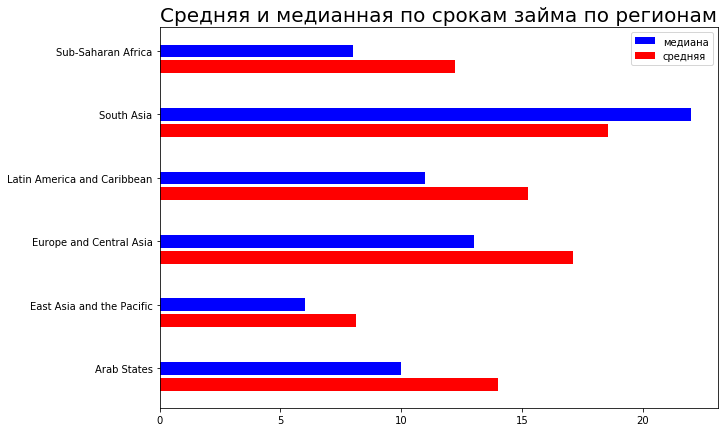

In [51]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes()

x = temp_df.index
xnum = range(temp_df.shape[0])
y = temp_df.time_mean
y1 = temp_df.time_median

time_mean = plt.barh([i + 0.05 for i in xnum], [i for i in y], height=0.2, color='red')
time_median = plt.barh([i + 0.3 for i in xnum], [i for i in y1], height=0.2, color='blue', tick_label=list(x))
plt.legend((time_median, time_mean), ('медиана', 'средняя'))
plt.title('Средняя и медианная по срокам займа по регионам',  fontsize=20);

plt.show;